This code effectively prepares a DataFrame to analyze trends in job skills demand by job title and month, based on the skills listed in job descriptions.

In [24]:
import pandas as pd

# Load data
df = pd.read_csv('job_descriptions_sample_5000.csv')

# Convert date to datetime
df['Job Posting Date'] = pd.to_datetime(df['Job Posting Date'])

# Normalize skills column: lowercase and strip spaces
df['skills'] = df['skills'].fillna('').apply(lambda x: [skill.strip().lower() for skill in x.split(',') if skill.strip()])

# Explode the skills column to have one skill per row
df_exploded = df.explode('skills')

# Add a monthly timestamp column
df_exploded['Month'] = df_exploded['Job Posting Date'].dt.to_period('M').dt.to_timestamp()

# Group by Job Title, Skill, and Month to count skill demand
skill_trend = df_exploded.groupby(['Job Title', 'skills', 'Month']).size().reset_index(name='Count')


In [25]:
from prophet import Prophet

# Filter for the selected Job Title: 'web developer'
target_title = 'web developer'
df_title = df_exploded[df_exploded['Job Title'].str.lower() == target_title]

# Group by Skill and Month
skill_trend = df_title.groupby(['skills', 'Month']).size().reset_index(name='Count')

# Identify top skill based on total count
top_skill = skill_trend.groupby('skills')['Count'].sum().sort_values(ascending=False).index[0]

# Extract data for the top skill
skill_data = skill_trend[skill_trend['skills'] == top_skill][['Month', 'Count']]

# Fix column renaming
skill_data = skill_data.rename(columns={'Month': 'ds', 'Count': 'y'})

# Train Prophet model
model = Prophet()
model.fit(skill_data)

# Forecast 6 future months
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

# View forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)



14:16:39 - cmdstanpy - INFO - Chain [1] start processing
14:16:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\sheha\anaconda3\envs\pylts\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
11,2023-06-30,1.351811,0.841410,1.826221
12,2023-07-31,1.365965,0.899397,1.823731
13,2023-08-31,1.380119,0.940223,1.859241
14,2023-09-30,1.393816,0.903517,1.866992
15,2023-10-31,1.407970,0.948451,1.918526
16,2023-11-30,1.421667,0.908586,1.924151


In [26]:
from prophet import Prophet

def forecast_top_skills(job_title, top_n=3, months_ahead=6):
    # Filter by job title
    df_title = df_exploded[df_exploded['Job Title'].str.lower() == job_title.lower()]
    
    if df_title.empty:
        return f"No data found for job title: {job_title}"
    
    # Group by skill and month
    skill_trend = df_title.groupby(['skills', 'Month']).size().reset_index(name='Count')
    
    # Get top N skills based on total usage
    top_skills = skill_trend.groupby('skills')['Count'].sum().sort_values(ascending=False).head(top_n).index.tolist()
    
    forecasts = {}
    
    for skill in top_skills:
        skill_data = skill_trend[skill_trend['skills'] == skill][['Month', 'Count']]
        skill_data = skill_data.rename(columns={'Month': 'ds', 'Count': 'y'})
        
        if len(skill_data) < 3:
            continue  # skip if not enough data
        
        model = Prophet()
        model.fit(skill_data)
        
        future = model.make_future_dataframe(periods=months_ahead, freq='MS')
        forecast = model.predict(future)
        
        forecast_future = forecast[['ds', 'yhat']].tail(months_ahead)
        forecasts[skill] = forecast_future.reset_index(drop=True)
    
    return forecasts


In [27]:
result = forecast_top_skills('web developer', top_n=3, months_ahead=6)
for skill, forecast_df in result.items():
    print(f"\nSkill: {skill}")
    print(forecast_df)

14:16:44 - cmdstanpy - INFO - Chain [1] start processing
14:16:44 - cmdstanpy - INFO - Chain [1] done processing
14:16:44 - cmdstanpy - INFO - Chain [1] start processing
14:16:44 - cmdstanpy - INFO - Chain [1] done processing
14:16:44 - cmdstanpy - INFO - Chain [1] start processing
14:16:44 - cmdstanpy - INFO - Chain [1] done processing



Skill: angular) user experience (ux)
          ds      yhat
0 2023-07-01  1.352267
1 2023-08-01  1.366421
2 2023-09-01  1.380575
3 2023-10-01  1.394273
4 2023-11-01  1.408427
5 2023-12-01  1.422124

Skill: css
          ds      yhat
0 2023-07-01  1.352267
1 2023-08-01  1.366421
2 2023-09-01  1.380575
3 2023-10-01  1.394273
4 2023-11-01  1.408427
5 2023-12-01  1.422124

Skill: html
          ds      yhat
0 2023-07-01  1.352267
1 2023-08-01  1.366421
2 2023-09-01  1.380575
3 2023-10-01  1.394273
4 2023-11-01  1.408427
5 2023-12-01  1.422124


14:16:46 - cmdstanpy - INFO - Chain [1] start processing
14:16:46 - cmdstanpy - INFO - Chain [1] done processing
14:16:46 - cmdstanpy - INFO - Chain [1] start processing
14:16:46 - cmdstanpy - INFO - Chain [1] done processing
14:16:46 - cmdstanpy - INFO - Chain [1] start processing
14:16:46 - cmdstanpy - INFO - Chain [1] done processing


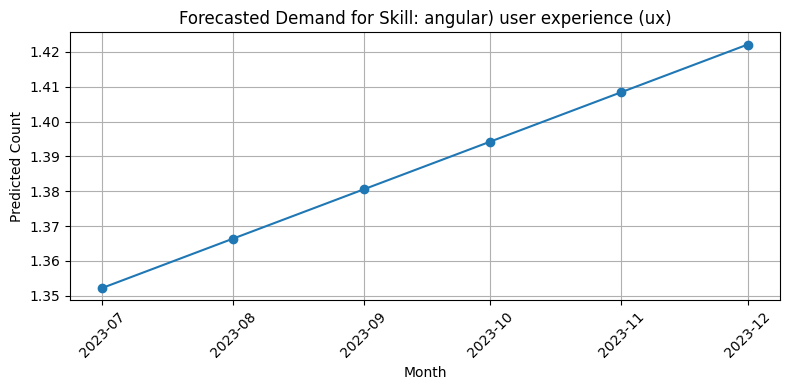

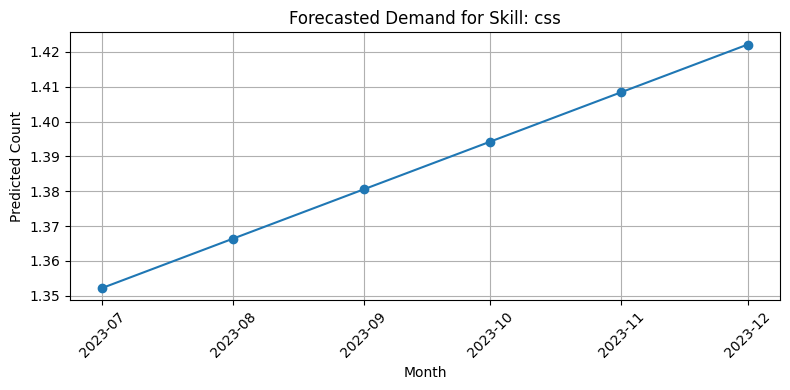

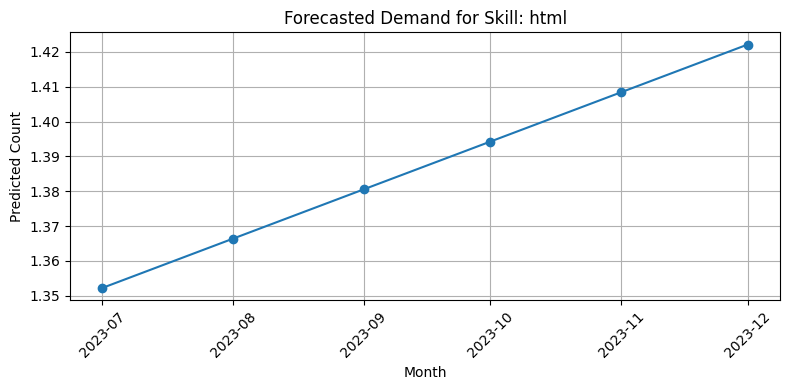

In [28]:
import matplotlib.pyplot as plt

# Call the forecasting function
result = forecast_top_skills('web developer', top_n=3, months_ahead=6)

# Plotting the forecasts
for skill, forecast_df in result.items():
    plt.figure(figsize=(8, 4))
    plt.plot(forecast_df['ds'], forecast_df['yhat'], marker='o')
    plt.title(f"Forecasted Demand for Skill: {skill}")
    plt.xlabel("Month")
    plt.ylabel("Predicted Count")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [29]:
from prophet import Prophet
import matplotlib.pyplot as plt

def forecast_skills_by_job_title(job_title, top_n=3, months_ahead=6):
    # Filter by job title
    df_title = df_exploded[df_exploded['Job Title'].str.lower() == job_title.lower()]
    
    if df_title.empty:
        print(f"No data found for job title: {job_title}")
        return
    
    # Group by skill and month
    skill_trend = df_title.groupby(['skills', 'Month']).size().reset_index(name='Count')
    
    # Get top N skills by total count
    top_skills = skill_trend.groupby('skills')['Count'].sum().sort_values(ascending=False).head(top_n).index.tolist()
    
    for skill in top_skills:
        skill_data = skill_trend[skill_trend['skills'] == skill][['Month', 'Count']]
        skill_data = skill_data.rename(columns={'Month': 'ds', 'Count': 'y'})
        
        if len(skill_data) < 3:
            continue  # Skip if not enough data points
        
        # Train Prophet model
        model = Prophet()
        model.fit(skill_data)
        
        # Forecast future months
        future = model.make_future_dataframe(periods=months_ahead, freq='MS')
        forecast = model.predict(future)
        
        # Plot forecast
        plt.figure(figsize=(10, 4))
        plt.plot(skill_data['ds'], skill_data['y'], label='Historical', marker='o')
        plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
        plt.title(f"Skill Forecast: {skill}")
        plt.xlabel("Date")
        plt.ylabel("Demand")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()


14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing


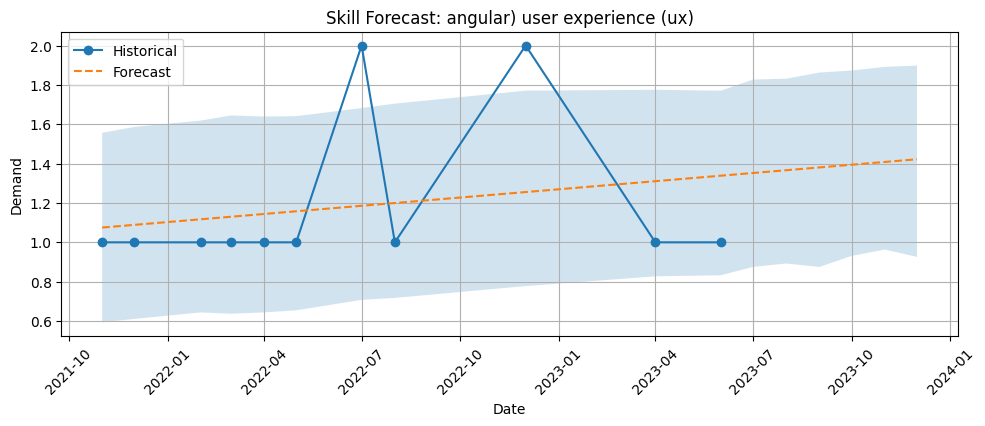

14:16:52 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing


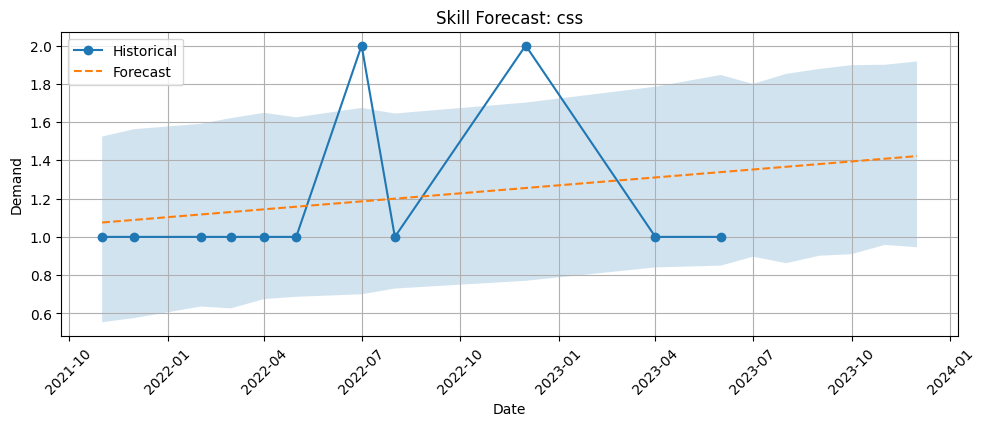

14:16:53 - cmdstanpy - INFO - Chain [1] start processing
14:16:53 - cmdstanpy - INFO - Chain [1] done processing


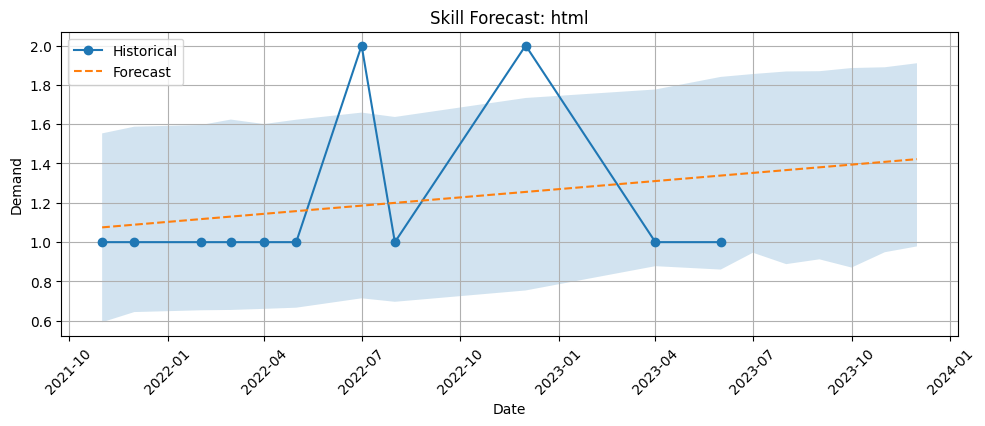

14:16:53 - cmdstanpy - INFO - Chain [1] start processing
14:16:53 - cmdstanpy - INFO - Chain [1] done processing


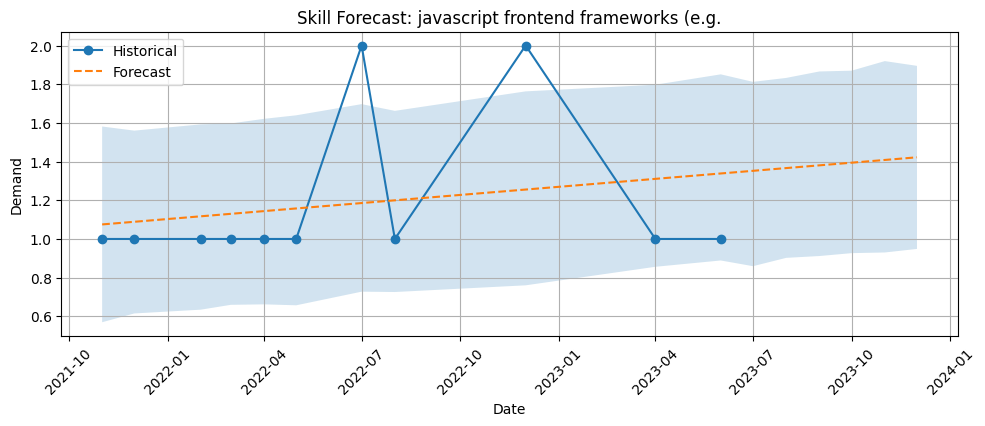

14:16:53 - cmdstanpy - INFO - Chain [1] start processing
14:16:53 - cmdstanpy - INFO - Chain [1] done processing


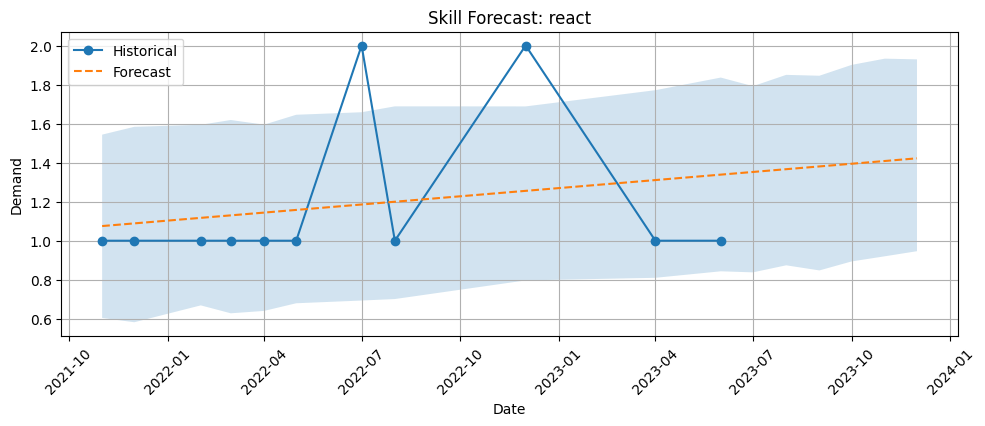

14:16:53 - cmdstanpy - INFO - Chain [1] start processing
14:16:53 - cmdstanpy - INFO - Chain [1] done processing


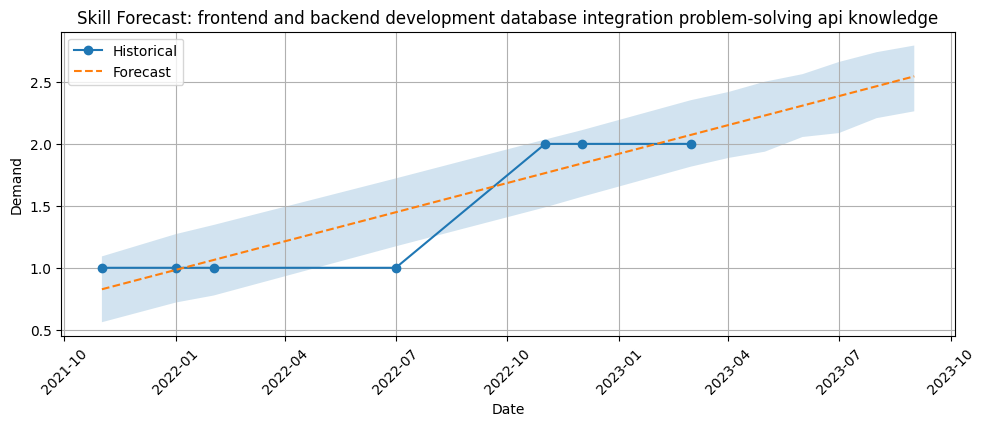

In [30]:
forecast_skills_by_job_title('web developer', top_n=6, months_ahead=6)

In [31]:
skill_trend.groupby('skills')['Count'].count().sort_values(ascending=False)


skills
angular) user experience (ux)                                                          11
css                                                                                    11
html                                                                                   11
javascript frontend frameworks (e.g.                                                   11
react                                                                                  11
mongodb)                                                                                8
node.js                                                                                 8
python) database management (e.g.                                                       8
server-side programming (e.g.                                                           8
sql                                                                                     8
frontend and backend development database integration problem-solving api knowledge     7
Nam

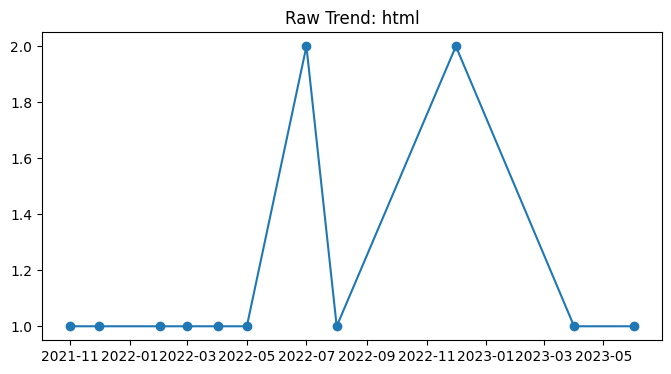

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(skill_data['ds'], skill_data['y'], marker='o')
plt.title(f"Raw Trend: {skill}")
plt.show()


14:18:57 - cmdstanpy - INFO - Chain [1] start processing
14:18:57 - cmdstanpy - INFO - Chain [1] done processing


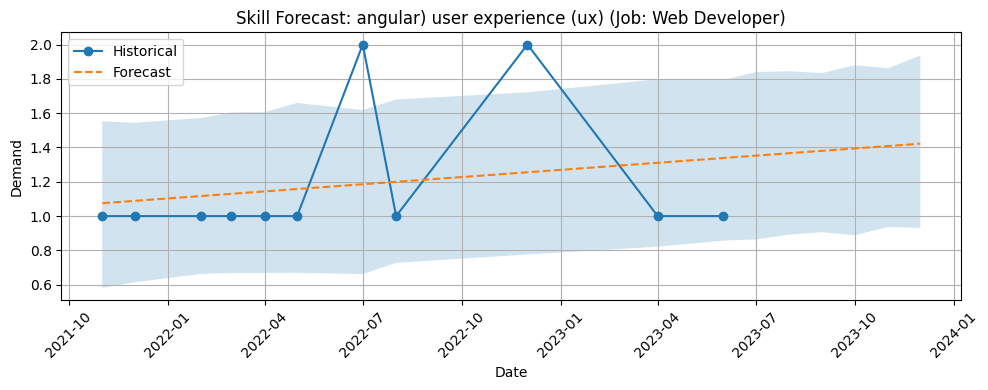

14:18:57 - cmdstanpy - INFO - Chain [1] start processing
14:18:57 - cmdstanpy - INFO - Chain [1] done processing


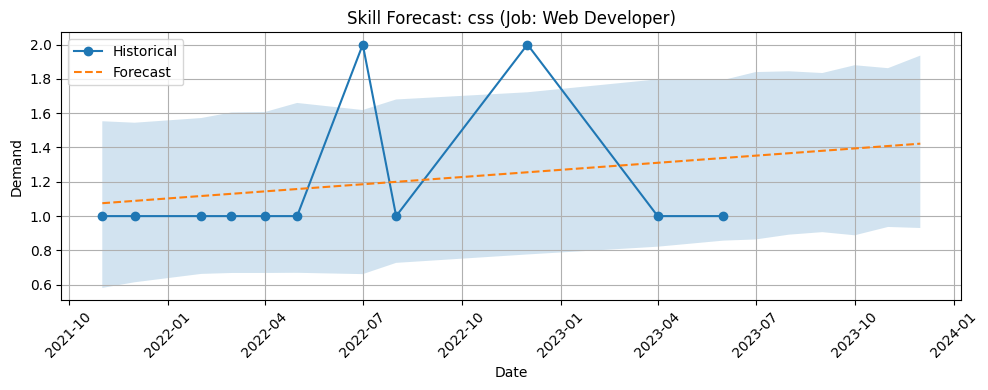

14:18:57 - cmdstanpy - INFO - Chain [1] start processing
14:18:57 - cmdstanpy - INFO - Chain [1] done processing


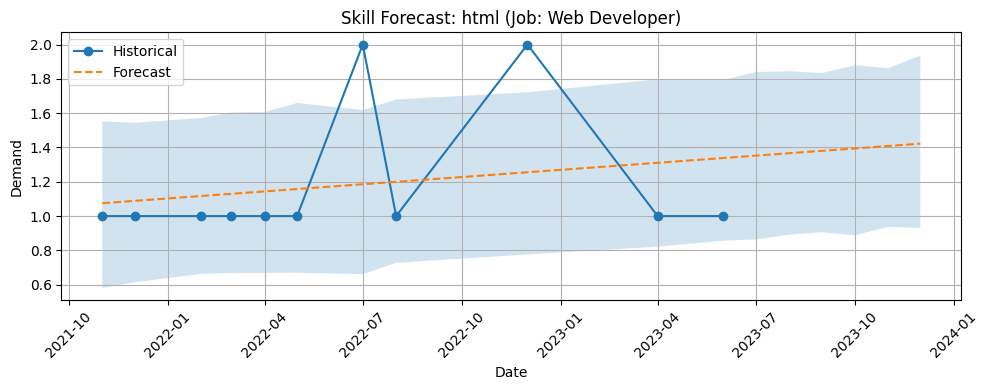

In [35]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv('Skill_Demand_Over_Time.csv')

# Filter for a specific job title
selected_title = 'Web Developer'
job_df = df[df['Job Title'].str.lower() == selected_title.lower()]

# Get top 3 skills by frequency
top_skills = job_df.groupby('Skill')['Count'].sum().sort_values(ascending=False).head(3).index.tolist()

# Forecast horizon
months_ahead = 6

for skill in top_skills:
    skill_df = job_df[job_df['Skill'] == skill][['Date', 'Count']]
    skill_df = skill_df.groupby('Date').sum().reset_index()
    skill_df = skill_df.rename(columns={'Date': 'ds', 'Count': 'y'})

    if len(skill_df) < 3:
        continue

    # Train model
    model = Prophet()
    model.fit(skill_df)

    # Forecast
    forecast['ds'] = pd.to_datetime(forecast['ds'])
    skill_df['ds'] = pd.to_datetime(skill_df['ds'])

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(skill_df['ds'], skill_df['y'], label='Historical', marker='o')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
    plt.title(f"Skill Forecast: {skill} (Job: {selected_title})")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [42]:
import pandas as pd
from prophet import Prophet

# Load your dataset
df = pd.read_csv("role_skill_frequency_updated.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Forecast skill demand for one skill
def forecast_skill_demand(df, role, skill, months_ahead=6):
    skill_ts = df[(df['Role'] == role) & (df['Skill'] == skill)][['Date', 'Frequency']]
    skill_ts = skill_ts.groupby('Date').sum().asfreq('MS').fillna(0).reset_index()
    skill_ts.columns = ['ds', 'y']
    
    if len(skill_ts) < 2:  # Skip if too little data
        return None, 0

    model = Prophet()
    model.fit(skill_ts)
    future = model.make_future_dataframe(periods=months_ahead, freq='MS')
    forecast = model.predict(future)
    forecast_sum = forecast[['ds', 'yhat']].tail(months_ahead)['yhat'].sum()
    return forecast[['ds', 'yhat']], forecast_sum

# Forecast all skills in a role
def forecast_all_skills(df, role, months_ahead=6):
    skills = df[df['Role'] == role]['Skill'].unique()
    results = {}
    for skill in skills:
        _, forecast_sum = forecast_skill_demand(df, role, skill, months_ahead)
        results[skill] = forecast_sum
    sorted_skills = sorted(results.items(), key=lambda x: x[1], reverse=True)
    return sorted_skills




In [ ]:
# Example usage
role = 'Web Developer'  
top_skills = forecast_all_skills(df, role, months_ahead=6)

14:53:05 - cmdstanpy - INFO - Chain [1] start processing
14:53:05 - cmdstanpy - INFO - Chain [1] done processing
14:53:05 - cmdstanpy - INFO - Chain [1] start processing
14:53:05 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
print(f"Top predicted skills for '{role}' in next 6 months:")
for skill, score in top_skills[:5]:
    print(f"{skill}: {round(score)} predicted mentions")

Top predicted skills for 'Web Developer' in next 6 months:
css: 74 predicted mentions
react: 27 predicted mentions
html: 22 predicted mentions
javascript frontend frameworks (e.g.: 13 predicted mentions
angular) user experience (ux): 13 predicted mentions
